In [1]:
import os
import re

#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
DATA_PATH = './codechef/'

def clean_statement(x):
    x = re.sub('All submissions for this problem are available', '', x)
    x = re.sub('Read problems statements in Mandarin Chinese|Russian|as well', '', x)
    x = re.sub('and|Vietnamese ', '', x)
    x = re.sub('n\'t', ' not', x)
    x = re.sub('-', ' ', x)
    x = re.sub('[,|.|?|\n]|\t', '', x)
    x = re.sub(' +', ' ', x)
    return x.strip()

In [2]:
from pyspark import SparkContext, SparkConf, HiveContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

import pandas as pd

spark = SparkSession.\
        builder.\
        appName("Codechef").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "16g").\
        enableHiveSupport(). \
        getOrCreate()

spark.conf.set("spark.sql.execution.arrow.enabled", "true")

def csv_to_spark_df(csv_path, list_clean_field=None):
    with open(csv_path, 'r') as f:
        columns = [col.strip() for col in  f.readline().split(',')]

    list_StructField = [StructField(col, StringType(), True) for col in columns]
    schema = StructType(list_StructField)
    df = spark.createDataFrame([], schema)

    for chunk in pd.read_csv(csv_path, chunksize=999999):
        for col in columns:
            chunk[col].fillna("", inplace=True)

        if list_clean_field != None:
            for field in list_clean_field:
                chunk[field] = [clean_statement(x) for x in chunk[field].values]

        chunk.head()
        spark_df = spark.createDataFrame(chunk)
        df = df.union(spark_df)

    return df

questions_df = csv_to_spark_df(DATA_PATH+'questions.csv', ['statement'])
questions_df.show()
questions_df.createOrReplaceTempView('Questions')

22/07/13 05:06:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/13 05:06:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
22/07/13 05:06:55 WARN TaskSetManager: Stage 1 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+------------------+--------+--------------------+------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   QCode|               Title|              link|   level|           statement|      Author|        Tester|           Editorial|                Tags|          Date Added|          Time Limit|        Source Limit|           Languages|
+--------+--------------------+------------------+--------+--------------------+------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|SEQUENCE|   Integer Sequences|/problems/SEQUENCE|  medium|For a fixed integ...|   friggstad|        pieguy|http://discuss.co...|['friggstad', 'co...|            30-01...|            4 sec...|            50000...|            <td>A...|
|CHEFTEAM|           Chef team|/problems/CHEFTEAM|    easy|C

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random

def showBarChart(title, names, values):
    colors_base = 'bgrcmy'
    color = random.choices(colors_base, k=len(names))
    plt.barh(names, values, align='center', color=color)
    for index, value in enumerate(values):
        plt.text(value, index, str(value))
    plt.title(title)
    plt.show()

def showPieChart(title, names, values):
    fig1, ax1 = mpl.pyplot.subplots()
    ax1.pie(values, labels=names, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()

22/07/12 17:05:10 WARN TaskSetManager: Stage 2 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:05:10 WARN TaskSetManager: Stage 4 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:05:11 WARN TaskSetManager: Stage 6 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:05:11 WARN TaskSetManager: Stage 8 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:05:11 WARN TaskSetManager: Stage 10 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


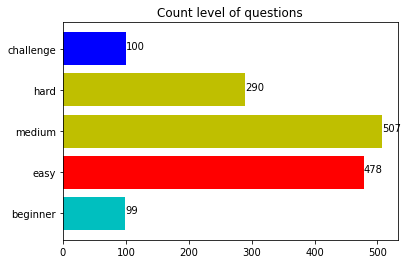

In [4]:
names = ['beginner', 'easy', 'medium', 'hard', 'challenge']
values = []
for name in names:
    rows = spark.sql(f'select count(Qcode) from Questions where level like "{name}"').collect()
    values.append(rows[0].__getitem__('count(Qcode)'))

showBarChart('Count level of questions', names, values)

22/07/12 17:05:11 WARN TaskSetManager: Stage 12 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


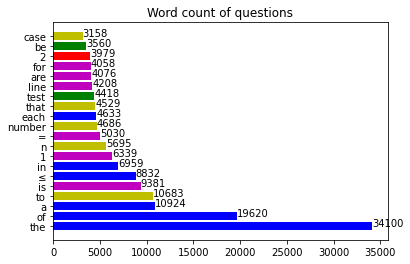

In [5]:
statements = spark.sql(f'select statement from Questions')
counts = statements.rdd.flatMap(lambda row: row.__getitem__('statement').split(' ')) \
        .map(lambda word: (word.lower(), 1)) \
        .reduceByKey(lambda x,y: x+y)

output = counts.collect()
output = sorted(output, key = lambda pair: pair[1], reverse=True)
names, values = [], []
for word, count in output[:20]:
    names.append(word)
    values.append(count)

showBarChart('Word count of questions', names, values)

In [5]:
solutions_df = csv_to_spark_df(DATA_PATH+'solutions.csv')
solutions_df.show()
solutions_df.createOrReplaceTempView('Solutions')

22/07/13 05:23:16 WARN TaskSetManager: Stage 3 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


+-----+----------+-----------------+------------------+-------------------+---------+--------+---------+--------------------+
|QCode|SolutionID|          timeago|            UserID|             Status|TimeTaken|MemTaken| Language|         SolutionUrl|
+-----+----------+-----------------+------------------+-------------------+---------+--------+---------+--------------------+
|   A1| S11986970|07:58 PM 31/10/16|/users/ismail_2311|           accepted|     1.43|      2M|        C|/viewplaintext/11...|
|   A1| S11990433|07:51 PM 01/11/16|   /users/mohit_15|       wrong answer|     0.00|      2M|        C|/viewplaintext/11...|
|   A1| S11990440|07:54 PM 01/11/16|   /users/mohit_15|           accepted|     0.00|      2M|        C|/viewplaintext/11...|
|   A1| S11995888|12:17 PM 03/11/16| /users/saloni1907|  compilation error|        -|       -|C++ 4.3.2|/viewplaintext/11...|
|   A1| S11995889|12:18 PM 03/11/16| /users/saloni1907|           accepted|     0.00|    2.7M|C++ 4.3.2|/viewplaintext

In [7]:
# https://sparkbyexamples.com/pyspark/pyspark-replace-column-values/

from pyspark.sql.functions import regexp_replace

solutions_df = solutions_df.withColumn('StatusGroup', regexp_replace('Status', '\(.*\)', ''))
solutions_df.show()
solutions_df.createOrReplaceTempView('Solutions')

22/07/12 17:05:15 WARN TaskSetManager: Stage 17 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


+-----+----------+-----------------+------------------+-------------------+---------+--------+---------+--------------------+-------------------+
|QCode|SolutionID|          timeago|            UserID|             Status|TimeTaken|MemTaken| Language|         SolutionUrl|        StatusGroup|
+-----+----------+-----------------+------------------+-------------------+---------+--------+---------+--------------------+-------------------+
|   A1| S11986970|07:58 PM 31/10/16|/users/ismail_2311|           accepted|     1.43|      2M|        C|/viewplaintext/11...|           accepted|
|   A1| S11990433|07:51 PM 01/11/16|   /users/mohit_15|       wrong answer|     0.00|      2M|        C|/viewplaintext/11...|       wrong answer|
|   A1| S11990440|07:54 PM 01/11/16|   /users/mohit_15|           accepted|     0.00|      2M|        C|/viewplaintext/11...|           accepted|
|   A1| S11995888|12:17 PM 03/11/16| /users/saloni1907|  compilation error|        -|       -|C++ 4.3.2|/viewplaintext/11...

22/07/12 17:05:16 WARN TaskSetManager: Stage 18 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


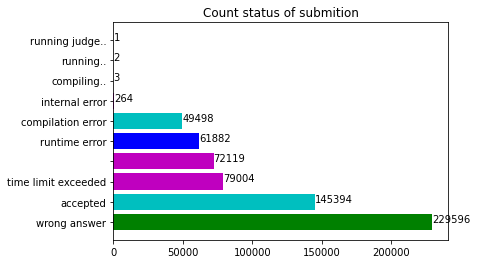

In [8]:
view = spark.sql(f'select StatusGroup, count(*) from Solutions group by StatusGroup')
output = view.rdd.map(lambda row: 
    (row.__getitem__('StatusGroup'), row.__getitem__('count(1)'))
).collect()
output = sorted(output, key = lambda ele: ele[1], reverse=True)

names, values = [], []
for word, count in output[:20]:
    names.append(word)
    values.append(count)

showBarChart('Count status of submition', names, values)

22/07/12 17:05:19 WARN TaskSetManager: Stage 20 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


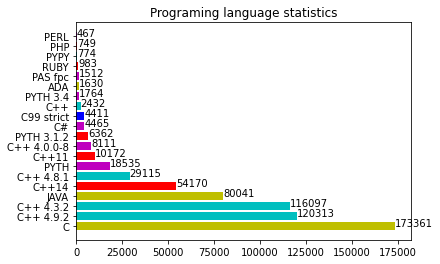

In [9]:
view = spark.sql(f'select Language, count(*) from Solutions group by Language')
output = view.rdd.map(
    lambda row: (row.__getitem__('Language'), row.__getitem__('count(1)'))
).collect()
output = sorted(output, key = lambda ele: ele[1], reverse=True)

names, values = [], []
for word, count in output[:20]:
    names.append(word)
    values.append(count)

showBarChart('Programing language statistics', names, values)

22/07/12 17:05:21 WARN TaskSetManager: Stage 22 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:05:22 WARN TaskSetManager: Stage 23 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:05:32 WARN TaskSetManager: Stage 43 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------+--------+--------------------+
|   QCode|accepted|submited|       success_ratio|
+--------+--------+--------+--------------------+
|CIELNUM2|     565|    2922| 0.19336071184120465|
|   CBARS|      40|      91| 0.43956043956043955|
|     WW2|      56|     144|  0.3888888888888889|
|ACMKANPE|       6|      60|                 0.1|
|BBSYSTEM|      45|     188|  0.2393617021276596|
|   DAGCH|      44|     103| 0.42718446601941745|
|  ANUTDP|     101|     514| 0.19649805447470817|
|  CHEFGM|     119|     389|  0.3059125964010283|
|  DIVPRO|       6|      22|  0.2727272727272727|
|ANKINTER|       9|     126| 0.07142857142857142|
|   CANDY|      25|     170| 0.14705882352941177|
|   CAOS1|     405|     961|  0.4214360041623309|
|   CROWD|     262|    1786| 0.14669652855543114|
|ASTRGAME|     187|    1325| 0.14113207547169812|
| BIGTREE|       1|     166|0.006024096385542169|
|  CFTREE|      99|     658| 0.15045592705167174|
|      D7|       4|      20|                 0.2|


22/07/12 17:05:33 WARN TaskSetManager: Stage 44 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


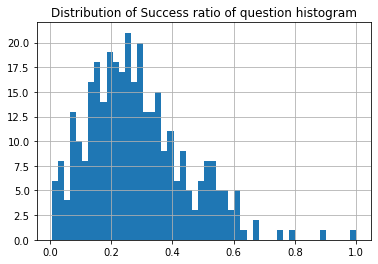

In [10]:
from pyspark.sql.functions import when

view = spark.sql(
    f'select Accepted.QCode, Accepted.accepted, Submited.submited from ' +
    f'(select QCode, count(*) as accepted from Solutions where StatusGroup like "accepted" group by QCode) Accepted ' +
    f'inner join (select QCode, count(*) as submited from Solutions group by QCode) Submited ' +
    f'on (Accepted.QCode like Submited.QCode)' 
)

questions_success_ratio = view.withColumn("success_ratio", view.accepted/view.submited)
#questions_success_ratio = questions_df.join(
#    questions_success_ratio,
#    questions_df.QCode == questions_success_ratio.QCode,
#    'left'
#).withColumn('success_ratio', 
#    when(questions_success_ratio['success_ratio'].isNull(), 0.0)
#    .otherwise(questions_success_ratio['success_ratio'])
#)

questions_success_ratio.show()

distributions = questions_success_ratio.rdd.map(
    lambda row: row.__getitem__('success_ratio')
).collect()

plt.hist(x=distributions, bins=50)
plt.title('Distribution of Success ratio of question histogram')
plt.grid(True)
plt.show()

In [11]:
from pyspark.sql.functions import col

success_to_level = questions_df.join(
    questions_success_ratio, 
    questions_df.QCode == questions_success_ratio.QCode,
    'inner'
).select(
    col('Accepted.QCode'),
    col('level'),
    col('Title'),
    col('statement'),
    col('success_ratio'),
).orderBy(col('Accepted.QCode').asc())

success_to_level.show()

22/07/12 17:10:05 WARN TaskSetManager: Stage 46 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:10:06 WARN TaskSetManager: Stage 47 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:10:06 WARN TaskSetManager: Stage 49 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------+--------------------+--------------------+-------------------+
|   QCode|   level|               Title|           statement|      success_ratio|
+--------+--------+--------------------+--------------------+-------------------+
|      A1|    easy|           Paying up|In the mysterious...| 0.4782608695652174|
|      A2|    easy|Johnny and the Be...|One evening Johnn...|               0.36|
|      A3|    easy|   The Guessing Game|Alice Johnny are ...|0.05890318212593094|
|      A4|    easy|The Rise and Fall...|Johnny was asked ...|0.06940200785683108|
|      A5|    hard|   Packing the Boxes|This problem was ...|0.09523809523809523|
|      A7|    hard|A Christmas Pizza...|This problem was ...| 0.2608695652173913|
|      A8|    hard|The Bytelandian U...|Bytel is a strang...| 0.0963855421686747|
|  ABCSTR|  medium|         ABC-Strings|Mike likes string...|              0.125|
|ACMKANPA|    hard|Problem With Strings|Today we will be ...|               0.08|
|ACMKANPB|  medi

In [12]:
success_to_level = success_to_level.withColumn('level', when(success_to_level['level'] == 'beginner', 0) \
        .when(success_to_level['level'] == 'easy', 1) \
        .when(success_to_level['level'] == 'medium', 2) \
        .when(success_to_level['level'] == 'hard', 3) \
        .when(success_to_level['level'] == 'challenge', 4) \
        .otherwise(success_to_level['level'])
)

success_to_level.show()
success_to_level.createOrReplaceTempView('SuccessToLevel')

22/07/12 17:11:15 WARN TaskSetManager: Stage 51 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:11:15 WARN TaskSetManager: Stage 52 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:11:16 WARN TaskSetManager: Stage 54 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.


+--------+-----+--------------------+--------------------+-------------------+
|   QCode|level|               Title|           statement|      success_ratio|
+--------+-----+--------------------+--------------------+-------------------+
|      A1|    1|           Paying up|In the mysterious...| 0.4782608695652174|
|      A2|    1|Johnny and the Be...|One evening Johnn...|               0.36|
|      A3|    1|   The Guessing Game|Alice Johnny are ...|0.05890318212593094|
|      A4|    1|The Rise and Fall...|Johnny was asked ...|0.06940200785683108|
|      A5|    3|   Packing the Boxes|This problem was ...|0.09523809523809523|
|      A7|    3|A Christmas Pizza...|This problem was ...| 0.2608695652173913|
|      A8|    3|The Bytelandian U...|Bytel is a strang...| 0.0963855421686747|
|  ABCSTR|    2|         ABC-Strings|Mike likes string...|              0.125|
|ACMKANPA|    3|Problem With Strings|Today we will be ...|               0.08|
|ACMKANPB|    2|               Bonus|Kinku is a proj

22/07/12 17:12:24 WARN TaskSetManager: Stage 56 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:12:24 WARN TaskSetManager: Stage 57 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:12:24 WARN TaskSetManager: Stage 58 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


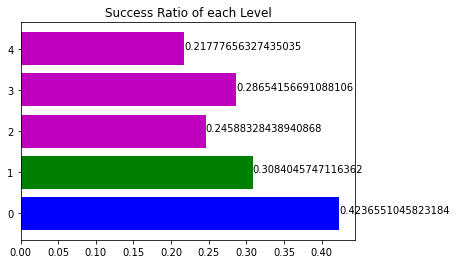

In [13]:
view = spark.sql(
    f'select level, AVG(success_ratio) from SuccessToLevel group by level'
).orderBy(col('level').asc())

output = view.rdd.map(
    lambda row: [row.__getitem__('level'), row.__getitem__('avg(success_ratio)')]
).collect()

names, values = [], []
for [name, value] in output:
    names.append(name)
    values.append(value)

showBarChart('Success Ratio of each Level', names, values)

22/07/13 05:23:29 WARN TaskSetManager: Stage 4 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


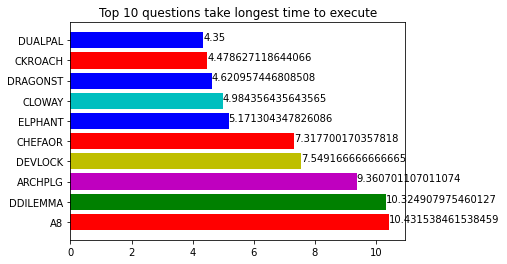

In [6]:
output = spark.sql(
    f'select * from ' +
        '(select QCode, AVG(TimeTaken) as avgTimeTaken from Solutions ' + 
            'where TimeTaken not like "-" '+ 
            'group by QCode ' +
            'order by avgTimeTaken DESC ' +
            'limit 10)'
).rdd.map(
    lambda row: [row.__getitem__('QCode'), row.__getitem__('avgTimeTaken')]
).collect()

names, values = [], []
for [name, value] in output:
    names.append(name)
    values.append(value)

showBarChart('Top 10 questions take longest time to execute', names, values)

22/07/13 05:23:51 WARN TaskSetManager: Stage 7 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


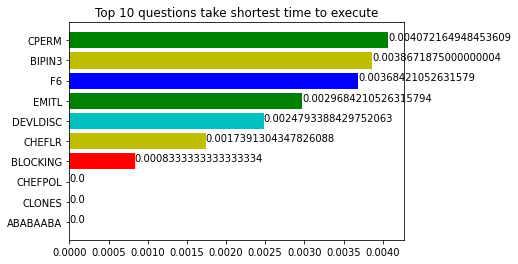

In [7]:
output = spark.sql(
    f'select * from ' +
        '(select * from ' + 
            '(select QCode, AVG(TimeTaken) as avgTimeTaken from Solutions ' + 
                'where TimeTaken not like "-" '+ 
                'group by QCode ' +
                'order by avgTimeTaken ASC) ' +
            'where avgTimeTaken >= 0) ' +
        'limit 10'
).rdd.map(
    lambda row: [row.__getitem__('QCode'), row.__getitem__('avgTimeTaken')]
).collect()

names, values = [], []
for [name, value] in output:
    names.append(name)
    values.append(value)

showBarChart('Top 10 questions take shortest time to execute', names, values)

22/07/13 05:24:17 WARN TaskSetManager: Stage 10 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


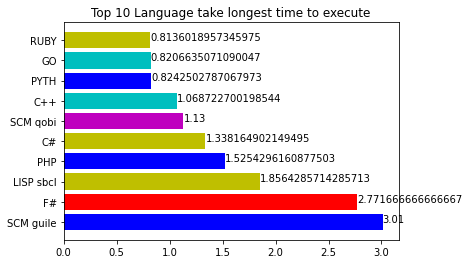

In [8]:
output = spark.sql(
    f'select * from ' +
        '(select Language, AVG(TimeTaken) as avgTimeTaken from Solutions ' + 
            'where TimeTaken not like "-" '+
            'group by Language ' +
            'order by avgTimeTaken DESC ' +
            'limit 10)'
).rdd.map(
    lambda row: [row.__getitem__('Language'), row.__getitem__('avgTimeTaken')]
).collect()

names, values = [], []
for [name, value] in output:
    names.append(name)
    values.append(value)

showBarChart('Top 10 Language take longest time to execute', names, values)

22/07/13 05:25:59 WARN TaskSetManager: Stage 13 contains a task of very large size (27006 KiB). The maximum recommended task size is 1000 KiB.


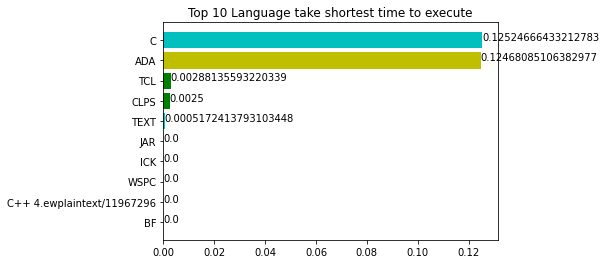

In [9]:
output = spark.sql(
    f'select * from ' +
        '(select * from ' + 
            '(select Language, AVG(TimeTaken) as avgTimeTaken from Solutions ' + 
                'where TimeTaken not like "-" '+ 
                'group by Language ' +
                'order by avgTimeTaken ASC) ' +
            'where avgTimeTaken >= 0) ' +
        'limit 10'
).rdd.map(
    lambda row: [row.__getitem__('Language'), row.__getitem__('avgTimeTaken')]
).collect()

names, values = [], []
for [name, value] in output:
    names.append(name)
    values.append(value)

showBarChart('Top 10 Language take shortest time to execute', names, values)

In [14]:
sols = pd.read_csv(DATA_PATH + '/solutions.csv', usecols=['QCode', 'SolutionID', 'Status', 'Language']).dropna()

first, second, third = [pd.read_csv(DATA_PATH + '/program_codes/'+i+'.csv') for i in 'first,second,third'.split(',')]

# Merge stuff
code = pd.concat([first, second, third])
code_df = sols.merge(code, how='left', on='SolutionID')
del(sols);del(code);del(first);del(second);del(third)

code_df = code_df.dropna()
code_df.info()
code_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565525 entries, 0 to 565643
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   QCode       565525 non-null  object
 1   SolutionID  565525 non-null  object
 2   Status      565525 non-null  object
 3   Language    565525 non-null  object
 4   Solutions   565525 non-null  object
dtypes: object(5)
memory usage: 25.9+ MB


,QCode,SolutionID,Status,Language,Solutions
0,A1,S11986970,accepted,C,\n #include <stdio.h>\n \n int power(...
1,A1,S11990433,wrong answer,C,\n #include <stdio.h>\n int recursivesum...
2,A1,S11990440,accepted,C,\n #include <stdio.h>\n int recursivesum...
3,A1,S11995888,compilation error,C++ 4.3.2,\n int main()\n {\n int t;\n ...
4,A1,S11995889,accepted,C++ 4.3.2,\n #include <iostream>\n #includ...


In [15]:
code_df=code_df.drop(columns=['Solutions'])
sol_codes = spark.createDataFrame(code_df)
sol_codes.show()
sol_codes.createOrReplaceTempView('Sol_codes')

+-----+----------+-------------------+---------+
|QCode|SolutionID|             Status| Language|
+-----+----------+-------------------+---------+
|   A1| S11986970|           accepted|        C|
|   A1| S11990433|       wrong answer|        C|
|   A1| S11990440|           accepted|        C|
|   A1| S11995888|  compilation error|C++ 4.3.2|
|   A1| S11995889|           accepted|C++ 4.3.2|
|   A1| S12033690|           accepted|     JAVA|
|   A1| S12046627|       wrong answer|C++ 4.3.2|
|   A1| S12048435|           accepted|     JAVA|
|   A1| S12050727|       wrong answer|C++ 4.9.2|
|   A1| S12050754|       wrong answer|C++ 4.9.2|
|   A1| S12050777|           accepted|C++ 4.9.2|
|   A1| S12074568|  compilation error|        C|
|   A1| S12081371|       wrong answer|    C++14|
|   A1| S12081644|           accepted|    C++14|
|   A1| S12090336|  compilation error|      ADA|
|   A1| S12090375|       wrong answer|        C|
|   A1| S12090400|time limit exceeded|        C|
|   A1| S12107279|  

22/07/12 17:16:33 WARN TaskSetManager: Stage 76 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


22/07/12 17:16:33 WARN TaskSetManager: Stage 77 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.
22/07/12 17:16:36 WARN TaskSetManager: Stage 79 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


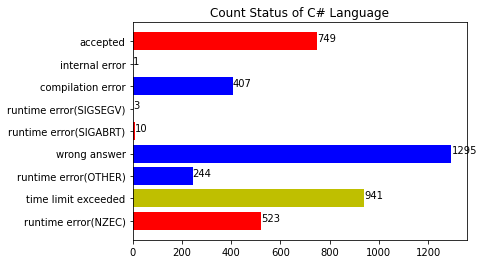

22/07/12 17:16:39 WARN TaskSetManager: Stage 81 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


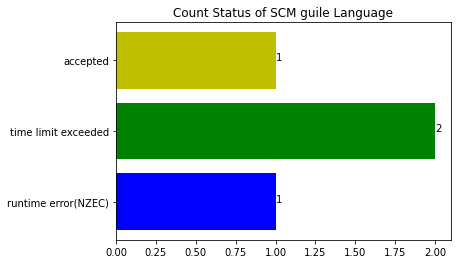

22/07/12 17:16:40 WARN TaskSetManager: Stage 83 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


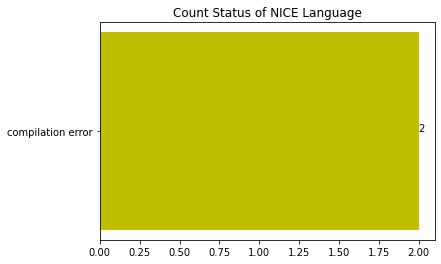

22/07/12 17:16:41 WARN TaskSetManager: Stage 85 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


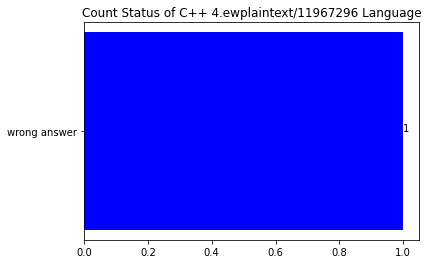

22/07/12 17:16:43 WARN TaskSetManager: Stage 87 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


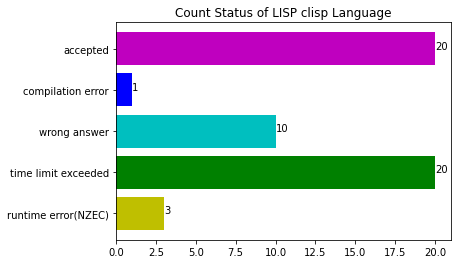

22/07/12 17:16:45 WARN TaskSetManager: Stage 89 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


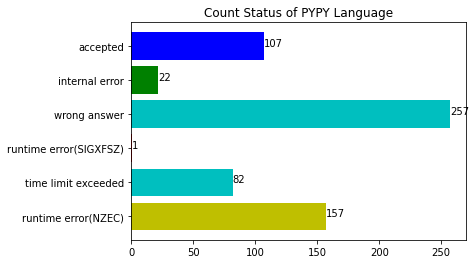

22/07/12 17:16:46 WARN TaskSetManager: Stage 91 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


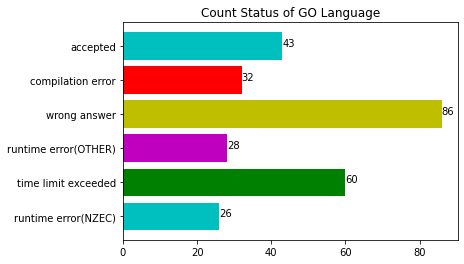

22/07/12 17:16:48 WARN TaskSetManager: Stage 93 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


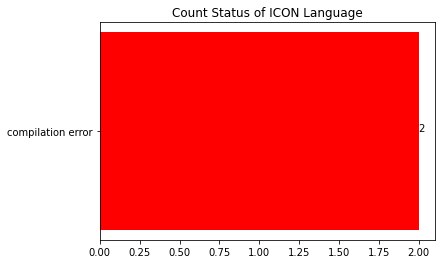

22/07/12 17:16:49 WARN TaskSetManager: Stage 95 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


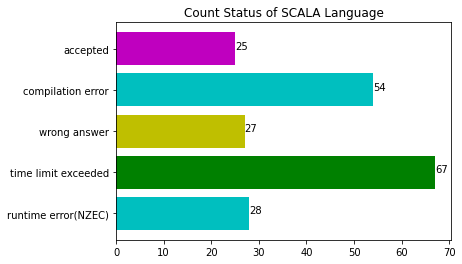

22/07/12 17:16:50 WARN TaskSetManager: Stage 97 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


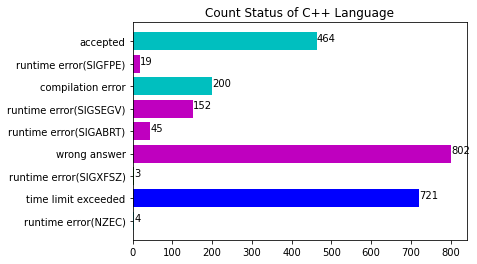

22/07/12 17:16:51 WARN TaskSetManager: Stage 99 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


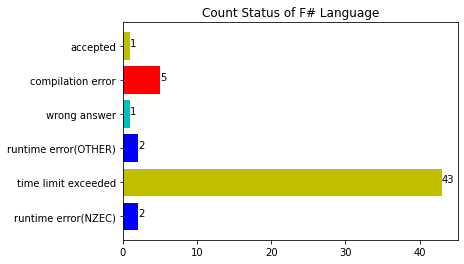

22/07/12 17:16:52 WARN TaskSetManager: Stage 101 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


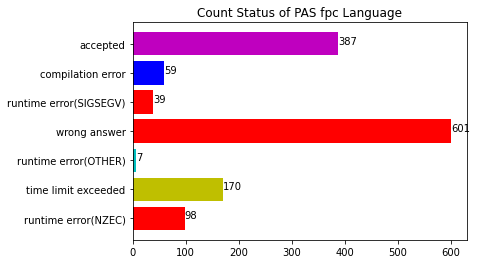

22/07/12 17:16:53 WARN TaskSetManager: Stage 103 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


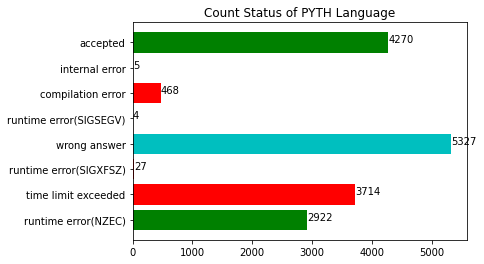

22/07/12 17:16:55 WARN TaskSetManager: Stage 105 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


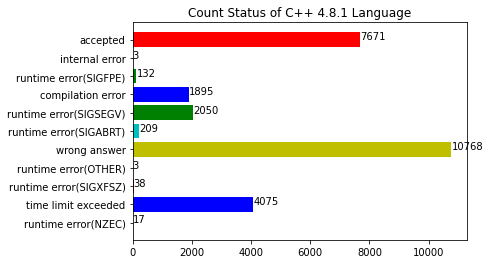

22/07/12 17:16:56 WARN TaskSetManager: Stage 107 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


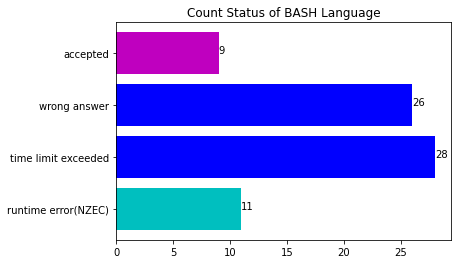

22/07/12 17:16:57 WARN TaskSetManager: Stage 109 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


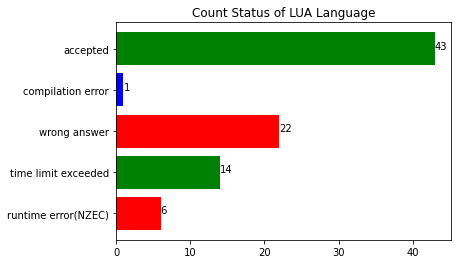

22/07/12 17:16:58 WARN TaskSetManager: Stage 111 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


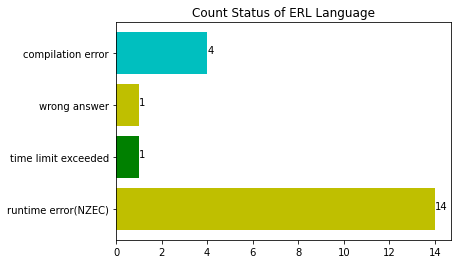

22/07/12 17:16:59 WARN TaskSetManager: Stage 113 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


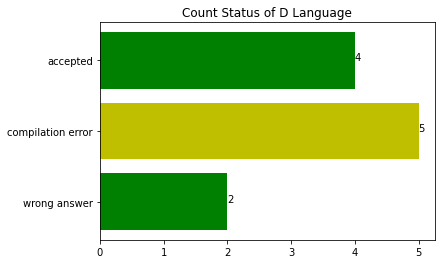

22/07/12 17:17:01 WARN TaskSetManager: Stage 115 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


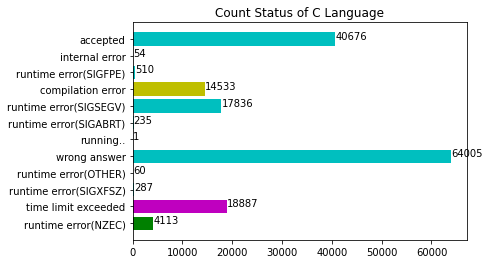

22/07/12 17:17:02 WARN TaskSetManager: Stage 117 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


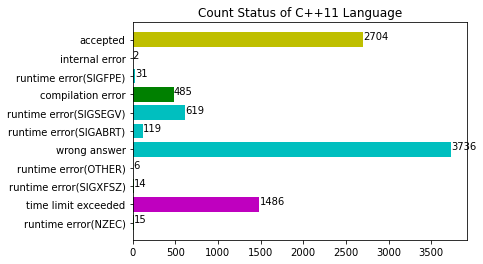

22/07/12 17:17:03 WARN TaskSetManager: Stage 119 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


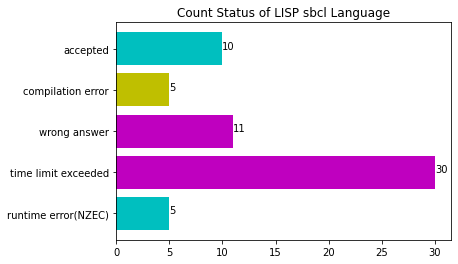

22/07/12 17:17:04 WARN TaskSetManager: Stage 121 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


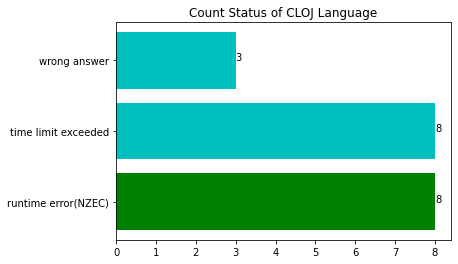

22/07/12 17:17:05 WARN TaskSetManager: Stage 123 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


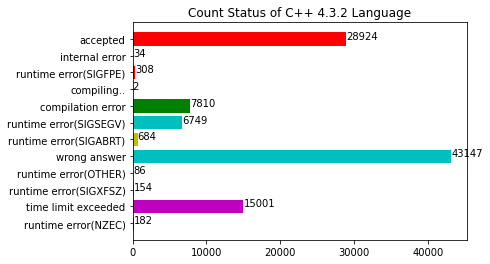

22/07/12 17:17:06 WARN TaskSetManager: Stage 125 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


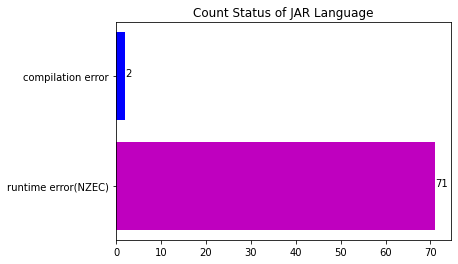

22/07/12 17:17:07 WARN TaskSetManager: Stage 127 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


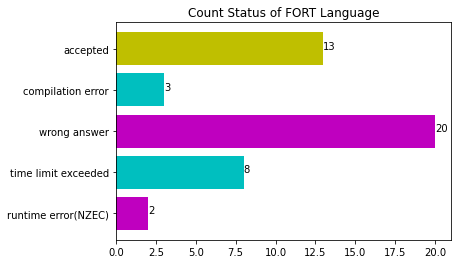

22/07/12 17:17:08 WARN TaskSetManager: Stage 129 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


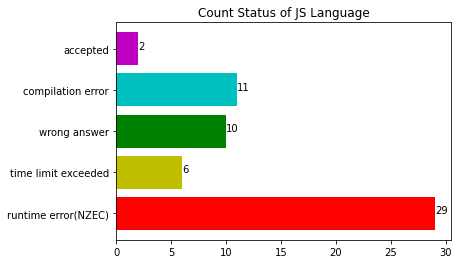

22/07/12 17:17:09 WARN TaskSetManager: Stage 131 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


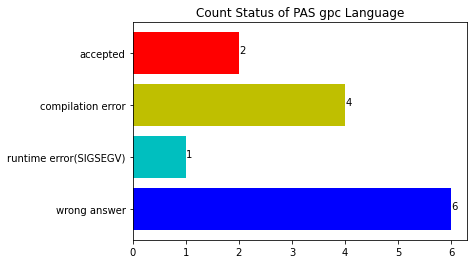

22/07/12 17:17:10 WARN TaskSetManager: Stage 133 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


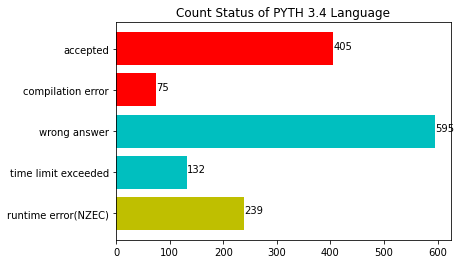

22/07/12 17:17:11 WARN TaskSetManager: Stage 135 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


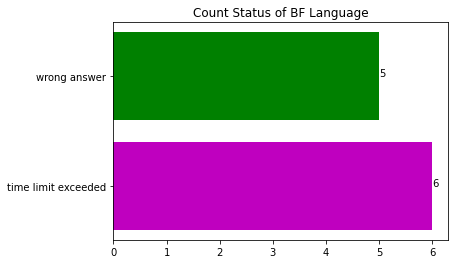

22/07/12 17:17:13 WARN TaskSetManager: Stage 137 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


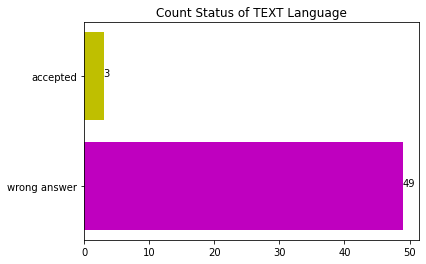

22/07/12 17:17:15 WARN TaskSetManager: Stage 139 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


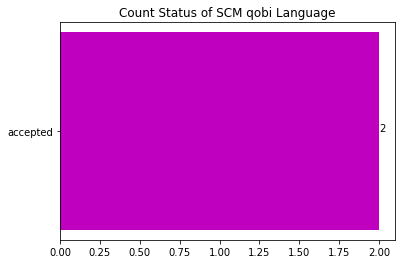

22/07/12 17:17:16 WARN TaskSetManager: Stage 141 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


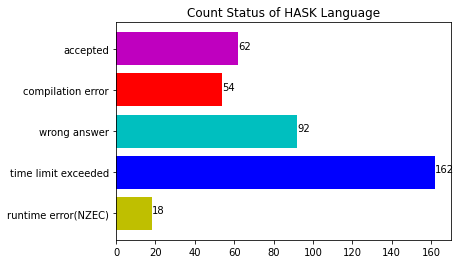

22/07/12 17:17:18 WARN TaskSetManager: Stage 143 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


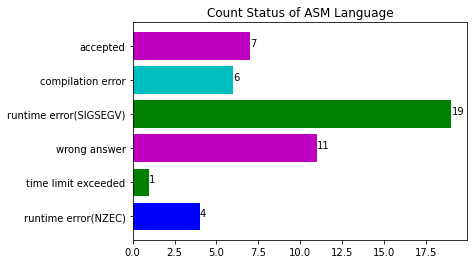

22/07/12 17:17:19 WARN TaskSetManager: Stage 145 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


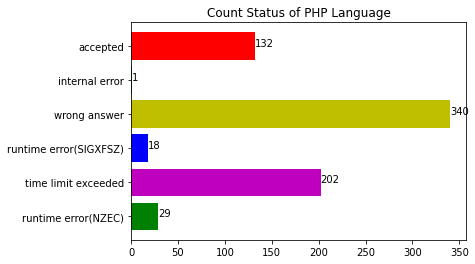

22/07/12 17:17:20 WARN TaskSetManager: Stage 147 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


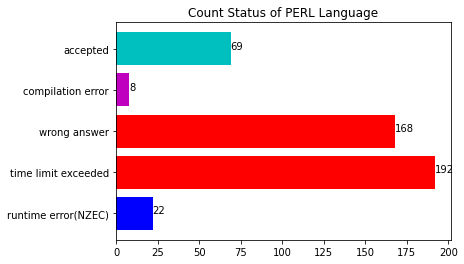

22/07/12 17:17:21 WARN TaskSetManager: Stage 149 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


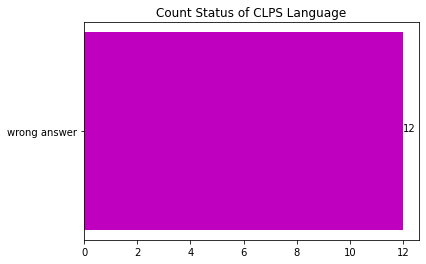

22/07/12 17:17:22 WARN TaskSetManager: Stage 151 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


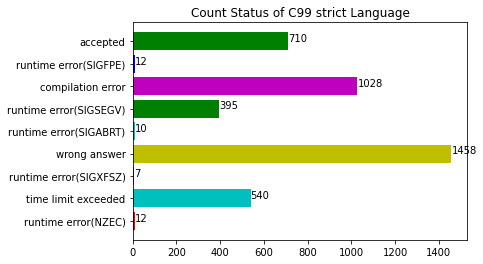

22/07/12 17:17:24 WARN TaskSetManager: Stage 153 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


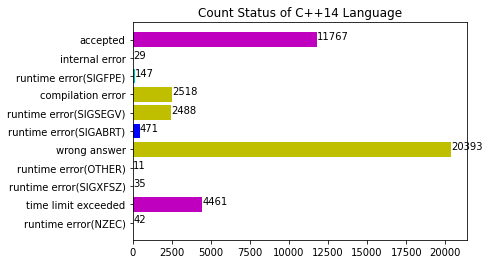

22/07/12 17:17:25 WARN TaskSetManager: Stage 155 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


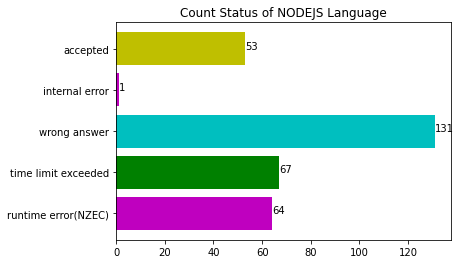

22/07/12 17:17:26 WARN TaskSetManager: Stage 157 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


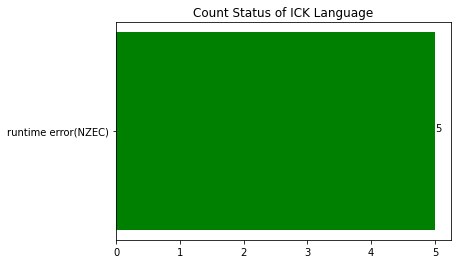

22/07/12 17:17:27 WARN TaskSetManager: Stage 159 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


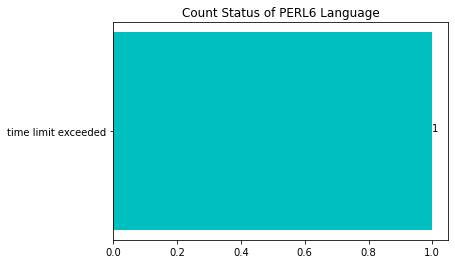

22/07/12 17:17:28 WARN TaskSetManager: Stage 161 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


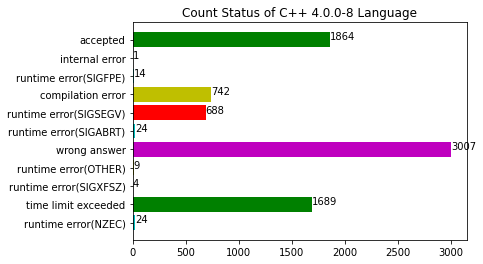

22/07/12 17:17:29 WARN TaskSetManager: Stage 163 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


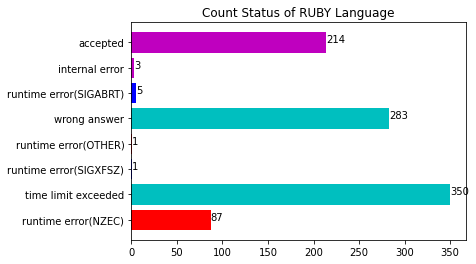

22/07/12 17:17:30 WARN TaskSetManager: Stage 165 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


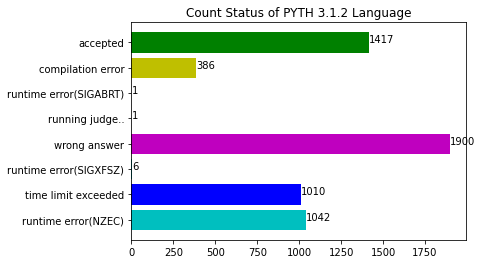

22/07/12 17:17:31 WARN TaskSetManager: Stage 167 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


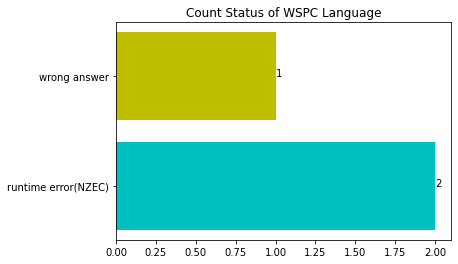

22/07/12 17:17:32 WARN TaskSetManager: Stage 169 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


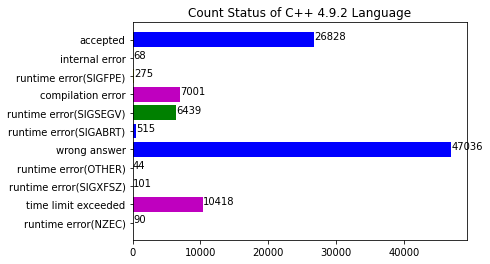

22/07/12 17:17:33 WARN TaskSetManager: Stage 171 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


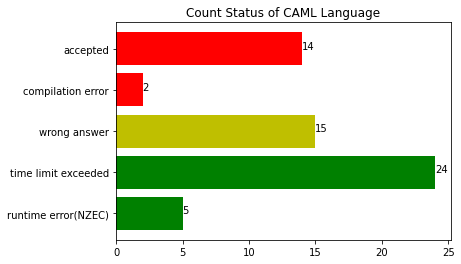

22/07/12 17:17:35 WARN TaskSetManager: Stage 173 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


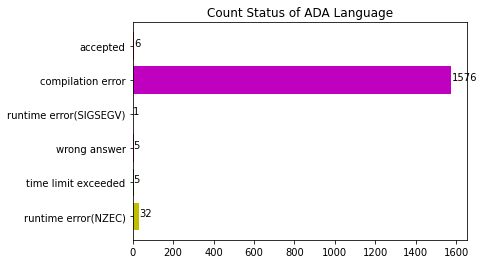

22/07/12 17:17:36 WARN TaskSetManager: Stage 175 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


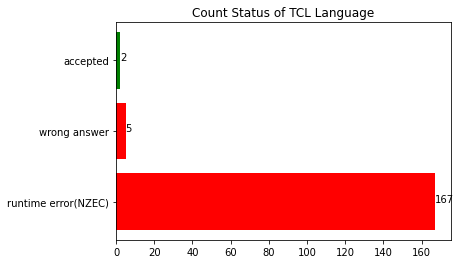

22/07/12 17:17:38 WARN TaskSetManager: Stage 177 contains a task of very large size (9097 KiB). The maximum recommended task size is 1000 KiB.


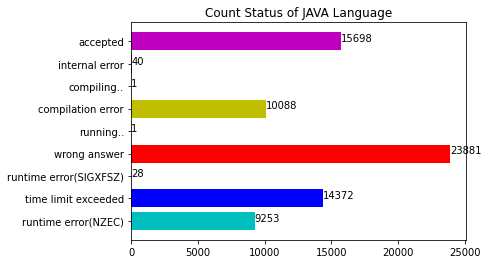

In [16]:
languages = spark.sql(
    f'select Language from Sol_codes group by Language'
).rdd.map(
    lambda row: row.__getitem__('Language')
).collect()

for ele in languages:
    output = spark.sql(
        f'select Status, count(*) from Sol_codes where Language like "{ele}" group by Status'
    ).rdd.map(
        lambda row: [row.__getitem__('Status'), row.__getitem__('count(1)')]
    ).collect()
    
    names, values = [], []
    for [name, value] in output:
        names.append(name)
        values.append(value)

    showBarChart(f'Count Status of {ele} Language', names, values)

In [10]:
!git init
!git add big_data_prj.ipynb
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/TrumThuyLoi/pyspark_codechef.git
!git push -u origin main

/bin/sh: 1: git: not found
/bin/sh: 1: git: not found
/bin/sh: 1: git: not found
/bin/sh: 1: git: not found
/bin/sh: 1: git: not found
/bin/sh: 1: git: not found
